# Convolutional autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py


In [4]:
from __future__ import division, print_function, absolute_import
%pylab inline
import wget
from scipy.io import wavfile
import librosa
import tensorflow as tf
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [35]:
def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [5]:
fname = 'Stockhausen_Kontakte.wav'

if not os.path.exists(fname):
    url = 'https://www.dropbox.com/s/f717af2vhiagcbp/'+fname+'?dl=1'
    filename = wget.download(url)

In [22]:
from scipy.signal import resample
# Read wav file to floating values
fs_orig,x = wavfile.read(fname)
fs = 22050
x = resample(x, x.size*fs/fs_orig)

t1 = 10*fs
t2 = 80*fs
x = x[t1:t2]
x = np.float64(x)/2**15
# Peak Normalization

x/=abs(x).max()

# Extract overlapping frames and create a spectrogram in each one

L = x.size

frame_size = 2**15
step_size = int(frame_size/2)

# Number of frames
n_frames = int( (L-frame_size)/step_size+1 )

block_size = 2**11
hop = int(block_size/4)
NFFT = block_size

level_threshold = 1e-5

n_blocks = int( (frame_size-block_size)/hop)+1+ int(block_size/hop)

S = []

# # STFT
# for i in range(n_frames):
#     frame = x[i*step_size:i*step_size+frame_size]
#     S_ = librosa.stft(frame,n_fft=NFFT,hop_length=hop,win_length=block_size )/2/NFFT
#     if abs(S_).mean()>level_threshold:
#         S_ = 20*log10(abs(S_)).clip(-60,0)
#         S_ = (S_ - S_.min()) /(S_.max() - S_.min())
#         S.append( S_ )

# CQT
S_ = []
n_bins = 65
for i in range(n_frames):
    frame = x[i*step_size:i*step_size+frame_size]
    rms = np.sqrt((frame**2).mean())
    if rms>level_threshold:
        S_.append( librosa.cqt(frame,sr=fs,hop_length=hop,fmin=40.0,n_bins=n_bins,real=False) )

max_ = max([abs(s).max() for s in S_])
S = []
for s in S_:
    s = 20*log10(abs(s/max_)).clip(-60,0)
    s = (s - s.min()) /(s.max() - s.min())
    S.append(s)
        

print(n_frames)
print("Dimensions: frames, freq bins, time bins")
S = np.array(S)
batch_length, freq_bins,time_bins = S.shape
print(batch_length, freq_bins,time_bins)


/usr/local/lib/python3.4/dist-packages/scipy/signal/signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


93
Dimensions: frames, freq bins, time bins
93 65 65


In [44]:
class Data():
    
    def __init__(self,data):
        import random
        
        self.data = data
        self.batch_ix = 0
        self.length = self.data.shape[0]
        self.ixs = list(range(self.length))
        random.shuffle(self.ixs)
        
    def next_batch(self,batch_size):
        self.batch_ix+= batch_size
        self.batch_ix = (self.batch_ix+batch_size) % self.length
        return self.data[self.ixs[self.batch_ix:self.batch_ix+batch_size]]
    
data = Data( S.reshape((S.shape[0],S.shape[1]*S.shape[2])) )
n_stfts = data.length


In [45]:
batch_size = 64
n_epochs = 100
learning_rate = 0.001
input_shape = [None, int(data.data.shape[1]) ]
n_filters=[1, 10, 10, 10]
filter_sizes=[5, 5, 5, 5]

In [47]:
def autoencoder(input_shape=[None, 784],
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3]):
    """Build a deep denoising autoencoder w/ tied weights.
    Parameters
    ----------
    input_shape : list, optional
        Description
    n_filters : list, optional
        Description
    filter_sizes : list, optional
        Description
    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    cost : Tensor
        Overall cost to use for training
    Raises
    ------
    ValueError
        Description
    """
    # %%
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')


    # %%
    # ensure 2-d is converted to square tensor.
    if len(x.get_shape()) == 2:
        x_dim = np.sqrt(x.get_shape().as_list()[1])
        if x_dim != int(x_dim):
            raise ValueError('Unsupported input dimensions')
        x_dim = int(x_dim)
        x_tensor = tf.reshape(
            x, [-1, x_dim, x_dim, n_filters[0]])
    elif len(x.get_shape()) == 4:
        x_tensor = x
    else:
        raise ValueError('Unsupported input dimensions')
    current_input = x_tensor

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        
        b = tf.Variable(tf.zeros([n_output]))
        
        encoder.append(W)
        
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        
        current_input = output

    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.pack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.reduce_mean(tf.square(y - x_tensor))

    # %%
    return {'x': x, 'z': z, 'y': y, 'cost': cost}
# %%

ae = autoencoder(input_shape=input_shape, n_filters=n_filters, filter_sizes=filter_sizes)

# %%

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# %%
# Fit all training data

total_batch = int(data.length/batch_size)
for epoch_i in range(n_epochs):
    for batch_i in range(total_batch):
        batch_xs = data.next_batch(batch_size)

        sess.run(optimizer, feed_dict={
            ae['x']: batch_xs })
        
    print(epoch_i, sess.run(ae['cost'], feed_dict={
        ae['x']: batch_xs}))

0 1528.31
1 1176.72
2 886.069
3 616.247
4 479.82
5 385.678
6 275.566
7 217.652
8 173.267
9 146.182
10 123.598
11 103.097
12 90.3413
13 83.3712
14 69.1757
15 60.2233
16 53.6972
17 48.8748
18 44.3763
19 39.8949
20 37.0561
21 36.9201
22 32.1693
23 29.793
24 27.9494
25 27.0523
26 26.0266
27 24.0152
28 23.1429
29 24.0451
30 21.1477
31 20.0981
32 19.0492
33 18.7041
34 17.9921
35 16.9115
36 16.2888
37 16.4562
38 15.2994
39 14.5409
40 14.0325
41 13.8182
42 13.5456
43 12.7005
44 12.2497
45 12.077
46 11.8204
47 11.2127
48 11.0207
49 10.8721
50 10.7939
51 10.1316
52 9.83071
53 9.30809
54 9.64392
55 9.25724
56 9.11178
57 8.96588
58 8.96396
59 8.56837
60 8.25101
61 8.05507
62 8.2057
63 7.96106
64 7.84343
65 7.69571
66 7.80133
67 7.45323
68 7.20449
69 7.71284
70 7.10829
71 6.97868
72 6.84037
73 6.71667
74 6.88697
75 6.58101
76 6.34639
77 6.20461
78 6.29002
79 6.13648
80 6.07989
81 5.99051
82 6.08898
83 5.91046
84 5.68455
85 5.70856
86 5.62707
87 5.44412
88 5.43581
89 5.36838
90 5.60904
91 5.33464
92

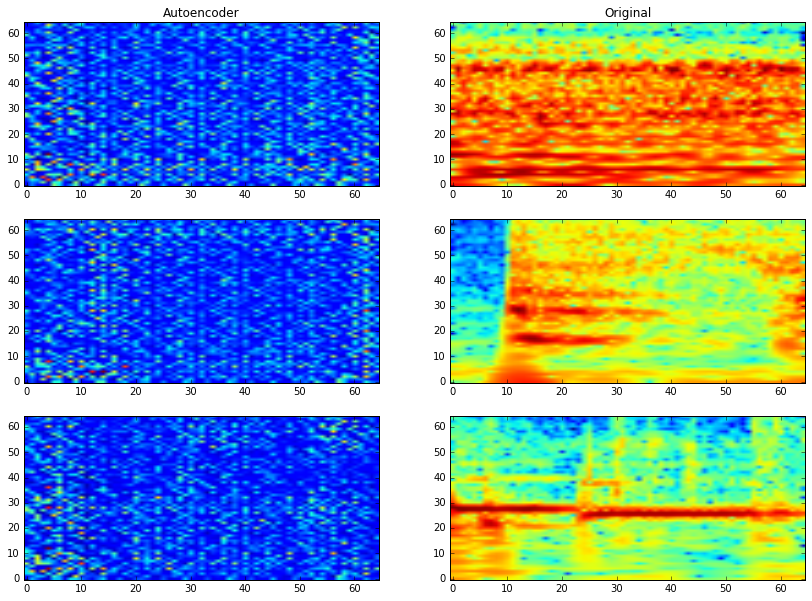

In [48]:
compare = [3,21,46]

recon = sess.run(ae['y'], feed_dict={ ae['x']: data.data[compare]})

original = data.data[compare]
figure(figsize=(14,10))
for i,c in enumerate(compare):
    
    subplot(len(compare),2,i*2+1)
    imshow(recon[i].reshape((freq_bins,time_bins)),aspect='auto',origin='bottom')
    subplot(len(compare),2,i*2+2)
    imshow(original[i].reshape((freq_bins,time_bins)),aspect='auto',origin='bottom')

subplot(len(compare),2,1)
title("Autoencoder")
subplot(len(compare),2,2)
title("Original")

# savefig("results_cqt_dim_"+str(dimensions)+"_cost_"+"{:.4f}.png".format(cost_value))

ValueError: too many values to unpack (expected 2)

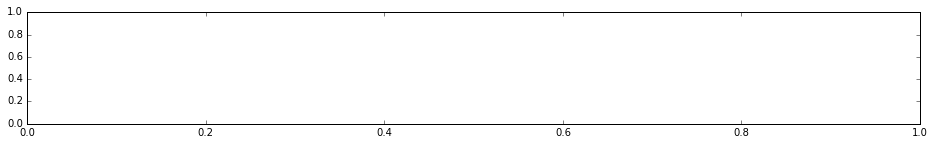

In [52]:
recon = sess.run(ae['z'], feed_dict={ ae['x']: data.data[21:22]})
matshow(recon)
colorbar()

In [54]:
recon.shape

(1, 9, 9, 10)

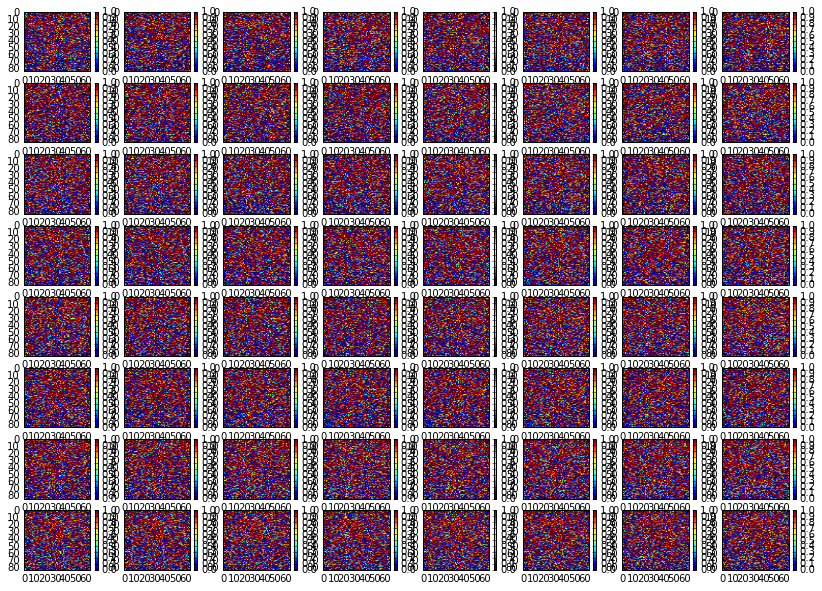

In [66]:
Y = np.zeros((1,dimensions[-1]),dtype=np.float32)
figure(figsize=(14,10))
for i in range(dimensions[-1]):
    Y[0,i] = 1
    out = sess.run(decoder(Y), feed_dict={X: data.data[3:4]})
    subplot(dimensions[-1]/8,8,i+1)
    imshow(out.reshape((freq_bins,time_bins)),aspect='auto')
    colorbar()

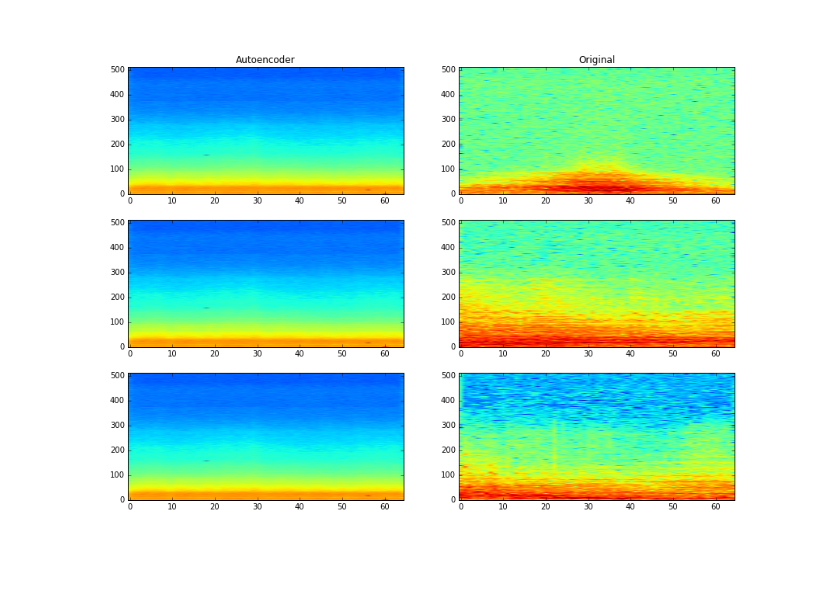

In [21]:
I = imread("results_dim_[256, 64]_cost_0.0082.png")
figure(figsize=(14,10))
imshow(I)
plt.axis('off');